In [103]:
print('start')

start


# Data Preprocessing

In [104]:
import pandas as pd
import numpy as np

In [105]:
data = pd.read_excel('Data/inflation.xlsx', parse_dates=True,index_col='Date')

In [106]:
data.info()
data.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 1994-07-01 to 2025-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    369 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


DatetimeIndex(['1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01',
               ...
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01',
               '2025-02-01', '2025-03-01'],
              dtype='datetime64[ns]', name='Date', length=369, freq=None)

In [107]:
data.head()

,rate
Date,
1994-07-01,0.0550
1994-08-01,0.0711
1994-09-01,0.0684
1994-10-01,0.0830
1994-11-01,0.0762


In [108]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Text(0, 0.5, 'CPI_rate')

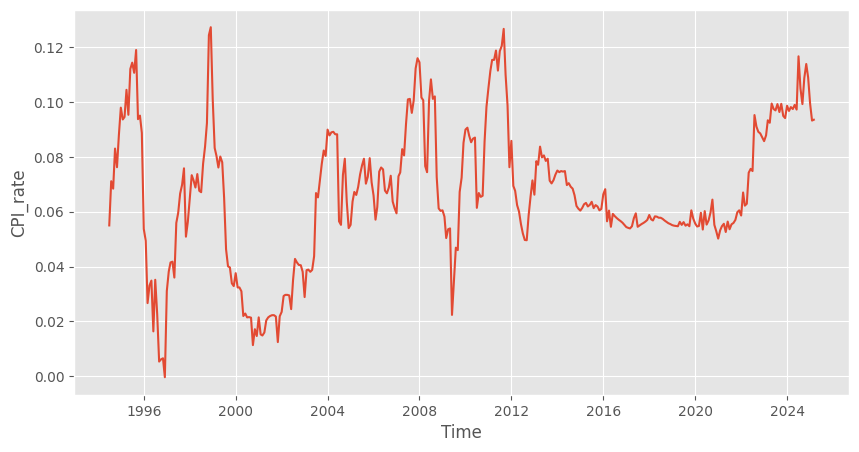

In [109]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(data.index, data['rate'])
ax.set_xlabel('Time')
ax.set_ylabel('CPI_rate')

The data is split into training and testing here according to 80-20 rule. 

In [110]:
train_size = int(len(data) * 0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

Checking for stationairty using ADF Test

In [111]:
from statsmodels.tsa.stattools import adfuller

In [112]:
adf = adfuller(train)
print(f'p-value is {np.round(adf[1],2)}')

p-value is 0.01


Plotting ACF and PACF

In [113]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

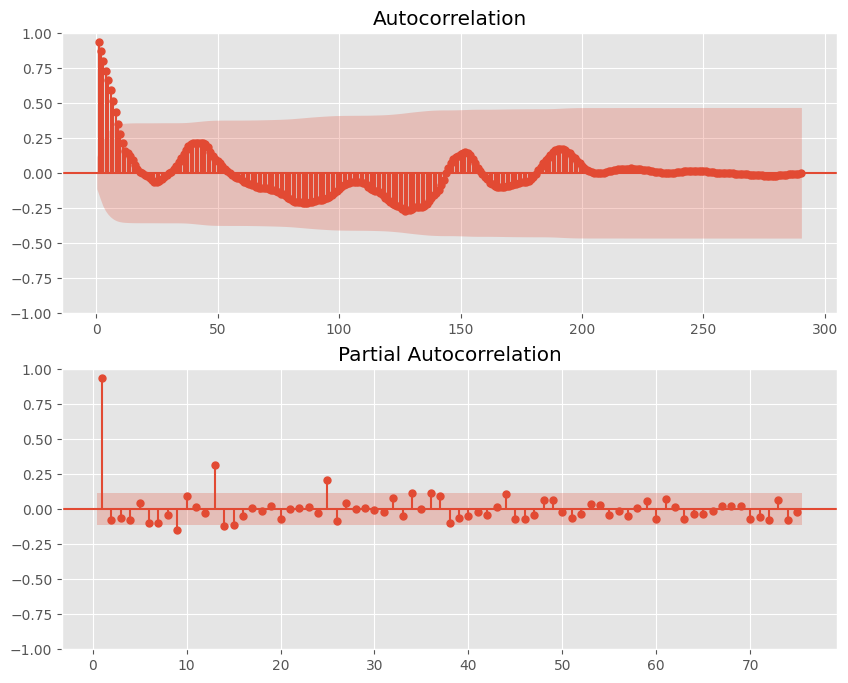

In [114]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (10, 8))
plot_acf(train, lags= 290, zero=False, ax=ax1)
plot_pacf(train, lags=75, zero=False, ax=ax2)
plt.show()

The ACF shows seasonal patters, whereas the PACF also exhibits some form of seasonality/cycle. However, we cannot discern the seasonality order from the ACF plot as there is no regular interval at which the spike occurs. Spectral decompsotion may help in this regard in dealing with the seasonality. <br>
First we will explore the ARIMA model and then fit SARIMA model to the inflation data.

##### Differencing the data

In [115]:
data_diff = data.diff().dropna()

In [116]:
train_diff = data_diff.iloc[:train_size]
test_diff = data_diff.iloc[train_size:]

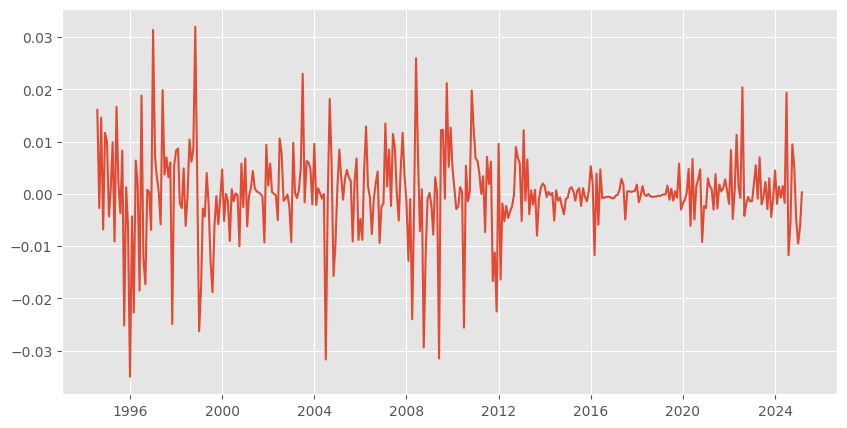

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(data_diff.index, data_diff['rate'])
plt.show()

In [118]:
adf_diff = adfuller(train_diff)
print(f'p-value is {np.round(adf_diff[1],5)} or differenced data')   

p-value is 0.0 or differenced data


Differencing the data also stabilized the variance.

Additionally, a Box-Cox transformation may prove to be useful in this scenario. The transformation requires that all the values are positive.

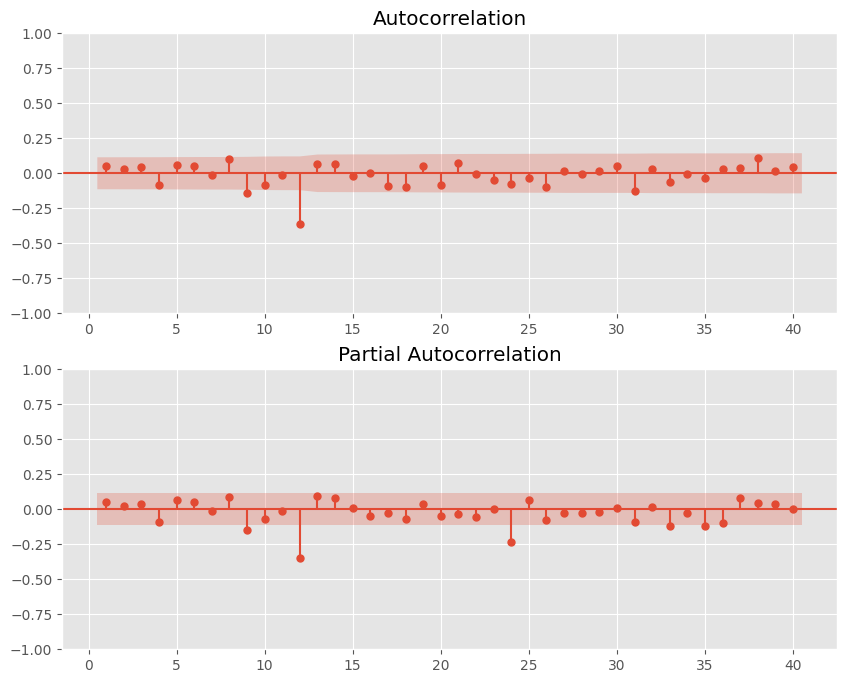

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (10, 8))
plot_acf(train_diff, lags= 40,  zero=False, ax=ax1)
plot_pacf(train_diff, lags=40, zero=False, ax=ax2)
plt.show()

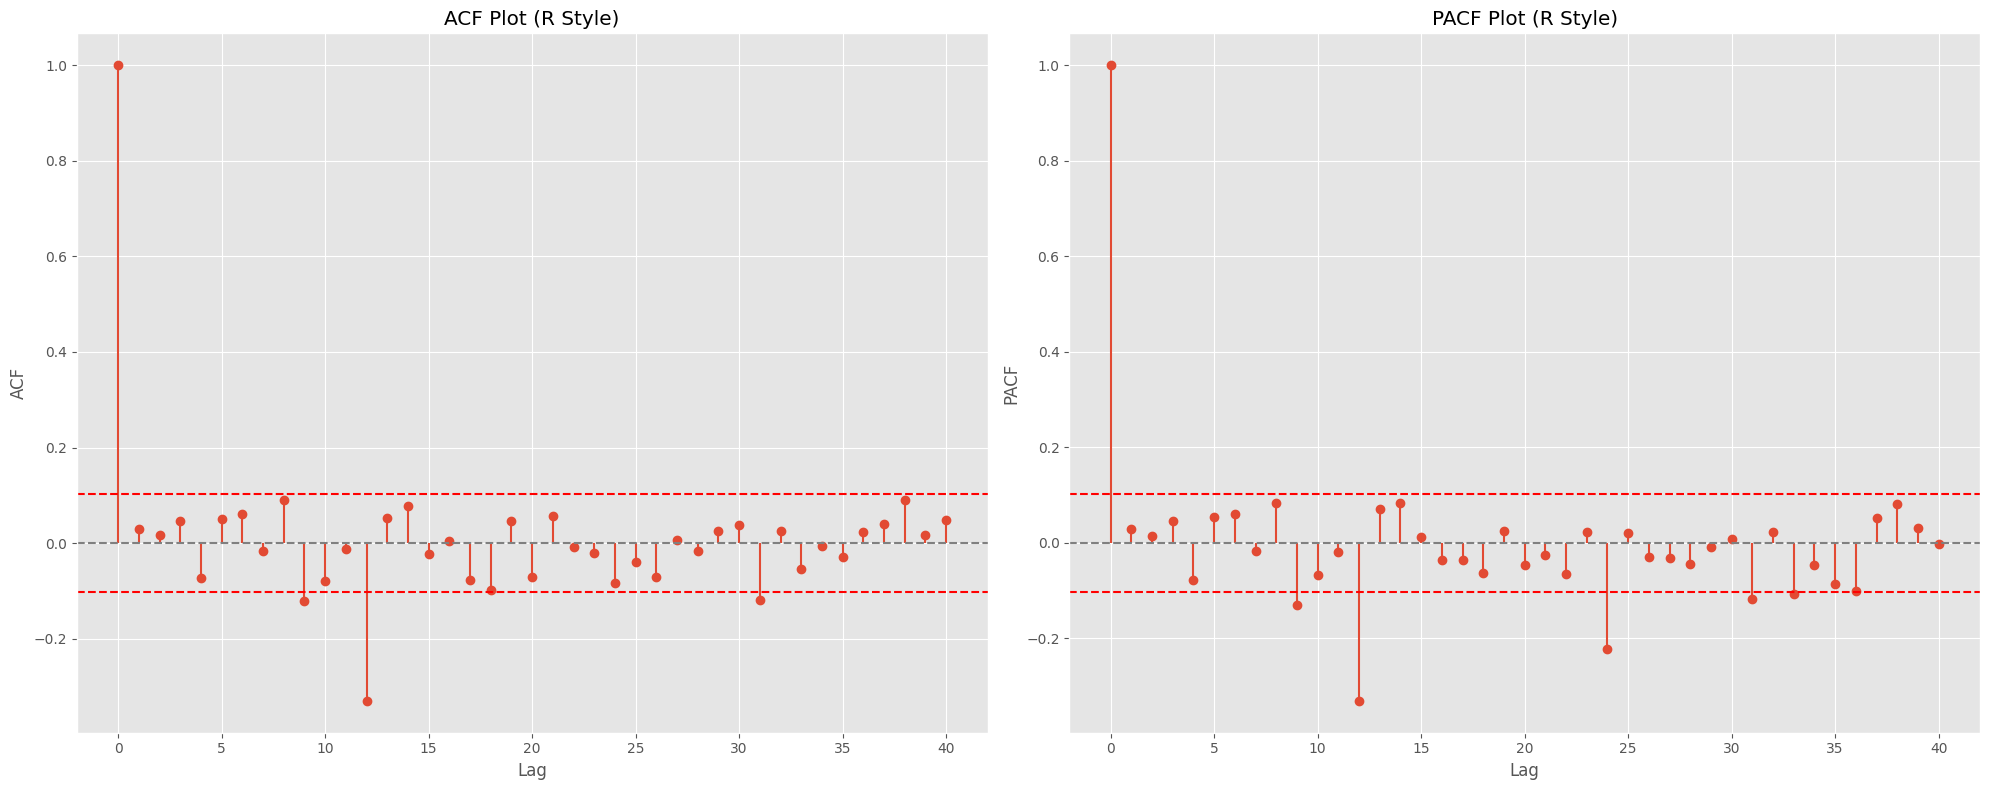

In [120]:
from statsmodels.graphics.tsaplots import acf, pacf
# Compute ACF and PACF values
acf_values = acf(data_diff['rate'], nlags=40)
pacf_values = pacf(data_diff['rate'], nlags=40)

# Generate lags for x-axis
lags = np.arange(len(acf_values))

# Plot ACF with lines
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.stem(lags, acf_values, basefmt=" ")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(data_diff['rate'])), linestyle='--', color='red')
plt.axhline(y=-1.96 / np.sqrt(len(data_diff['rate'])), linestyle='--', color='red')
plt.title('ACF Plot (R Style)')
plt.xlabel('Lag')
plt.ylabel('ACF')

# Plot PACF with lines
plt.subplot(122)
plt.stem(lags, pacf_values, basefmt=" ")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(data_diff['rate'])), linestyle='--', color='red')
plt.axhline(y=-1.96 / np.sqrt(len(data_diff['rate'])), linestyle='--', color='red')
plt.title('PACF Plot (R Style)')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()


The ACF and the PACF plots of the differenced time series data does not show any pattern. As a result, the correlograms are not sufficient in order to find the best fit model. Instead, we will find the best fit model using AIC and BIC for various p's and q's.

In [121]:
# Using non-differenced data for exploring
order_aic_bic = []
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(train, order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)
order_df = pd.DataFrame(order_aic_bic, columns = ['p','q','aic','bic'])

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

In [122]:
order_df.sort_values('aic').head(3)

,p,q,aic,bic
9,2,1,-1949.926802,-1931.491925
8,2,0,-1947.220351,-1932.472449
4,1,0,-1947.138197,-1936.077270


In [123]:
order_df.sort_values('bic').head(3)

,p,q,aic,bic
4,1,0,-1947.138197,-1936.077270
8,2,0,-1947.220351,-1932.472449
5,1,1,-1946.969003,-1932.221101


The non-differenced data prefers ARIMA(2,0,1) based on AIC while it preders ARIMA(1,0,0) based on bic.

In [124]:
# Here d = 1
order_aic_bic = []
for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(train, order=(p,1,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)
order_df = pd.DataFrame(order_aic_bic, columns = ['p','q','aic','bic'])

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

In [125]:
order_df.sort_values('aic').head(2)

,p,q,aic,bic
8,2,2,-1937.177064,-1918.759165
0,0,0,-1936.713127,-1933.029547


In [126]:
order_df.sort_values('bic').head(2)

,p,q,aic,bic
0,0,0,-1936.713127,-1933.029547
3,1,0,-1935.497891,-1928.130731


The differenced data prefers ARIMA(2,1,2) based on AIC and ARIMA(0,1,0) based on BIC.

#### Model Diagnostics

ARIMA(2,1,2) fit

In [127]:
model = ARIMA(train, order=(2,1,2))
results = model.fit()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [128]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   rate   No. Observations:                  295
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 973.589
Date:                Sat, 10 May 2025   AIC                          -1937.177
Time:                        11:43:10   BIC                          -1918.759
Sample:                    07-01-1994   HQIC                         -1929.801
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1607      0.491     -0.327      0.744      -1.124       0.802
ar.L2          0.7086      0.438      1.617      0.106      -0.150       1.567
ma.L1          0.2624      0.516      0.509      0.6

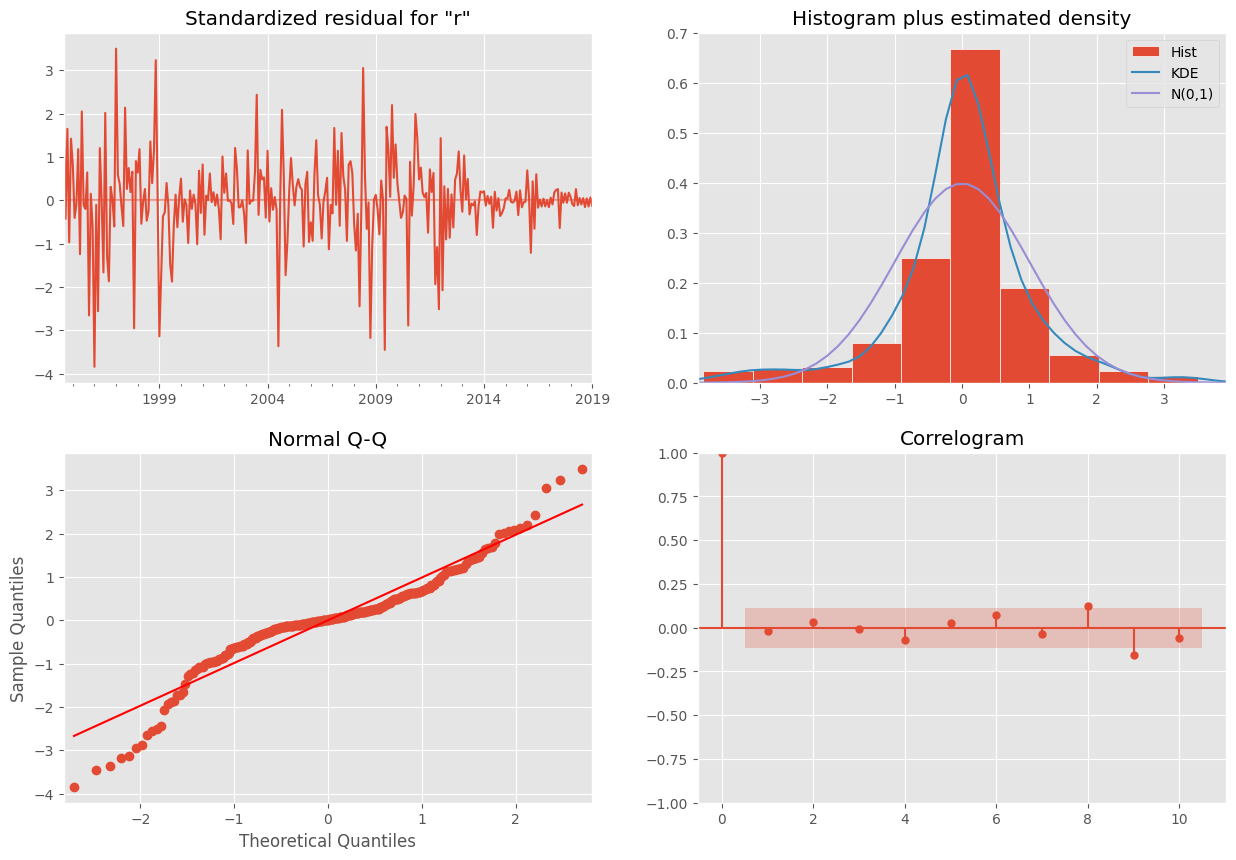

In [129]:
fig = results.plot_diagnostics(figsize=(15, 10))
plt.show()


Accordding to the model diagnostics, the normality assumption of the model is being violated. Applying Box-Cox transformation may help.

ARMA(2, 1) fit on the differenced data

In [150]:
model = ARIMA(data_diff.rate, order=(2,0,1))
results = model.fit()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertib

In [151]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   rate   No. Observations:                  368
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1239.561
Date:                Sat, 10 May 2025   AIC                          -2469.122
Time:                        12:41:53   BIC                          -2449.581
Sample:                    08-01-1994   HQIC                         -2461.358
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.228      0.819      -0.001       0.001
ar.L1       1.065e-06      0.026   4.16e-05      1.000      -0.050       0.050
ar.L2       5.857e-07      0.036   1.61e-05      1.0

In [174]:
model = ARIMA(data_diff.rate, order=(2,1,1))
results = model.fit()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [175]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   rate   No. Observations:                  368
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1232.972
Date:                Sat, 10 May 2025   AIC                          -2457.943
Time:                        12:46:34   BIC                          -2442.322
Sample:                    08-01-1994   HQIC                         -2451.736
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0337      0.053      0.638      0.523      -0.070       0.137
ar.L2          0.0183      0.036      0.502      0.616      -0.053       0.090
ma.L1         -0.9988      0.154     -6.482      0.0

#### Box-Cox Transformation

Box-Cox transformation requires that the data is non-negative. There is only one instance in the dataset where the inflation rate is negative. The data is dropped for this analysis.

In [130]:
(train < 0).sum()

rate    1
dtype: int64

In [131]:
train[train['rate'] < 0]

,rate
Date,
1996-12-01,-0.0003


In [132]:
train_new = train.drop('1996-12-01')

In [133]:
(train_new < 0).sum()

rate    0
dtype: int64

In [138]:
from scipy.stats import boxcox
import seaborn as sns

<Axes: xlabel='rate', ylabel='Count'>

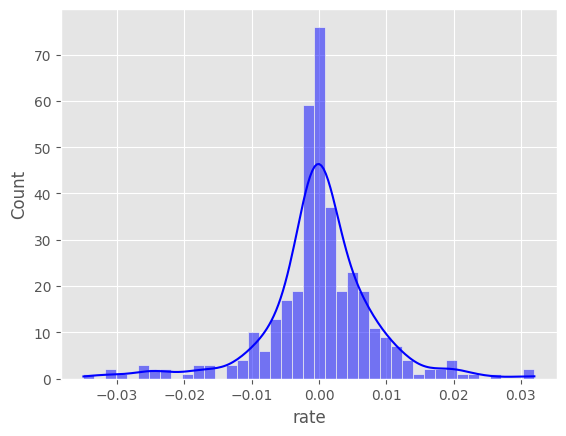

In [149]:
sns.histplot(data_diff['rate'], kde=True, color='blue')

Optimal Lambda: 0.9271721257797447


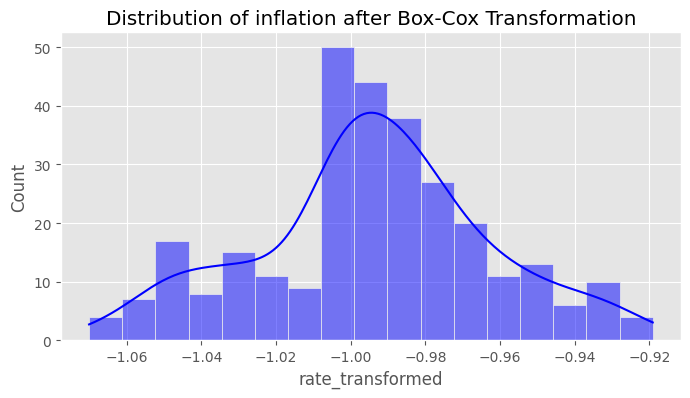

In [141]:
# Applying Box-Cox Transformation
train_new['rate_transformed'], lam = boxcox(train_new['rate'])
print(f"Optimal Lambda: {lam}")

# Plot the distribution of transformed data
plt.figure(figsize=(8, 4))
sns.histplot(train_new['rate_transformed'], kde=True, color='blue')
plt.title('Distribution of inflation after Box-Cox Transformation')
plt.show()

In [143]:
model = ARIMA(train_new['rate_transformed'], order=(2,1,2))
results = model.fit()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting a

In [144]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:       rate_transformed   No. Observations:                  294
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 909.345
Date:                Sat, 10 May 2025   AIC                          -1808.691
Time:                        12:29:36   BIC                          -1790.290
Sample:                             0   HQIC                         -1801.321
                                - 294                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0254      3.925      0.006      0.995      -7.667       7.718
ar.L2          0.0140      1.921      0.007      0.994      -3.752       3.780
ma.L1          0.0261      3.921      0.007      0.9

Since the adfuller test showed non-existence of unit roots, therefore, to fit ARIMA model, we need not detrend it further, rather we can just take the logarithm to stabilize the variance. But before that we just fit ARIMA(1,0,1) to have a baseline model of the data, which we would like to improve by further analysis. The RMSE off the test data is the metric to be compared.

### Baseline ARIMA (for non-differenced data)

Applying baseline ARIMA to non-differenced data

In [135]:
from statsmodels.tsa.arima.model import ARIMA

In [136]:
model = ARIMA(data['rate'], order=(1,0,1))
results = model.fit()
print(results.summary())

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   rate   No. Observations:                  369
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1247.666
Date:                Sat, 10 May 2025   AIC                          -2487.332
Time:                        11:43:12   BIC                          -2471.689
Sample:                    07-01-1994   HQIC                         -2481.118
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0664      0.008      8.573      0.000       0.051       0.082
ar.L1          0.9404      0.017     54.223      0.000       0.906       0.974
ma.L1          0.0607      0.057      1.070      0.2

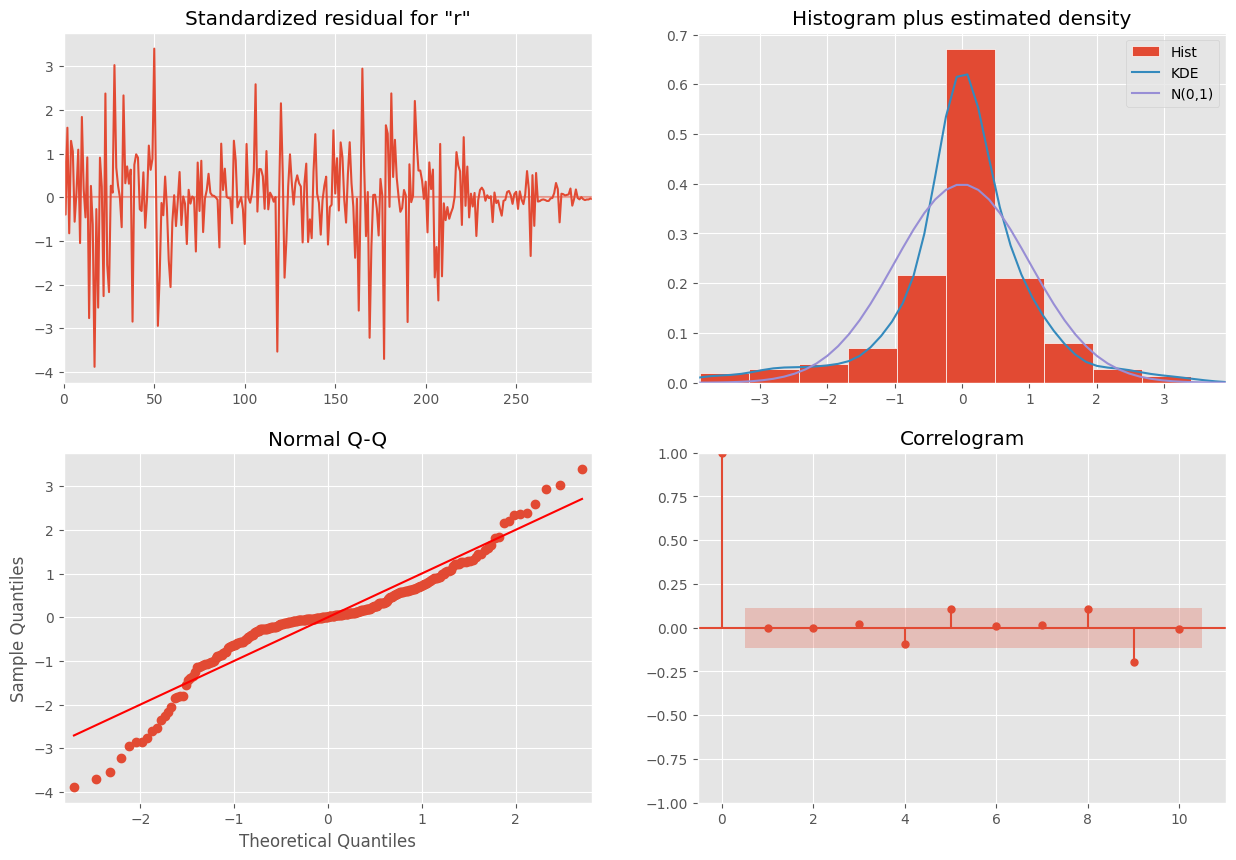

In [145]:
fig = results.plot_diagnostics(figsize=(15, 10))
plt.show()


# Forecasting

## In-sample Forecasting

## Out-sample Forecasting

## Comparison of models usig RMSE

## Dealing with seasonality

In [137]:
model = ARIMA(data['log_diff_1'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

KeyError: 'log_diff_1'

In [ ]:
data

,rate,diff_1,log_rate,log_diff_1
Date,,,,
2015-04-01,0.0632,NaN,-2.761451,NaN
2015-05-01,0.0619,-0.0013,-2.782235,-0.020784
2015-06-01,0.0625,0.0006,-2.772589,0.009646
2015-07-01,0.0636,0.0011,-2.755142,0.017447
2015-08-01,0.0613,-0.0023,-2.791975,-0.036834
...,...,...,...,...
2024-11-01,0.1138,0.0051,-2.173313,0.045851
2024-12-01,0.1089,-0.0049,-2.217325,-0.044012
2025-01-01,0.0994,-0.0095,-2.308603,-0.091278


In [ ]:
import statsmodels.api as sm

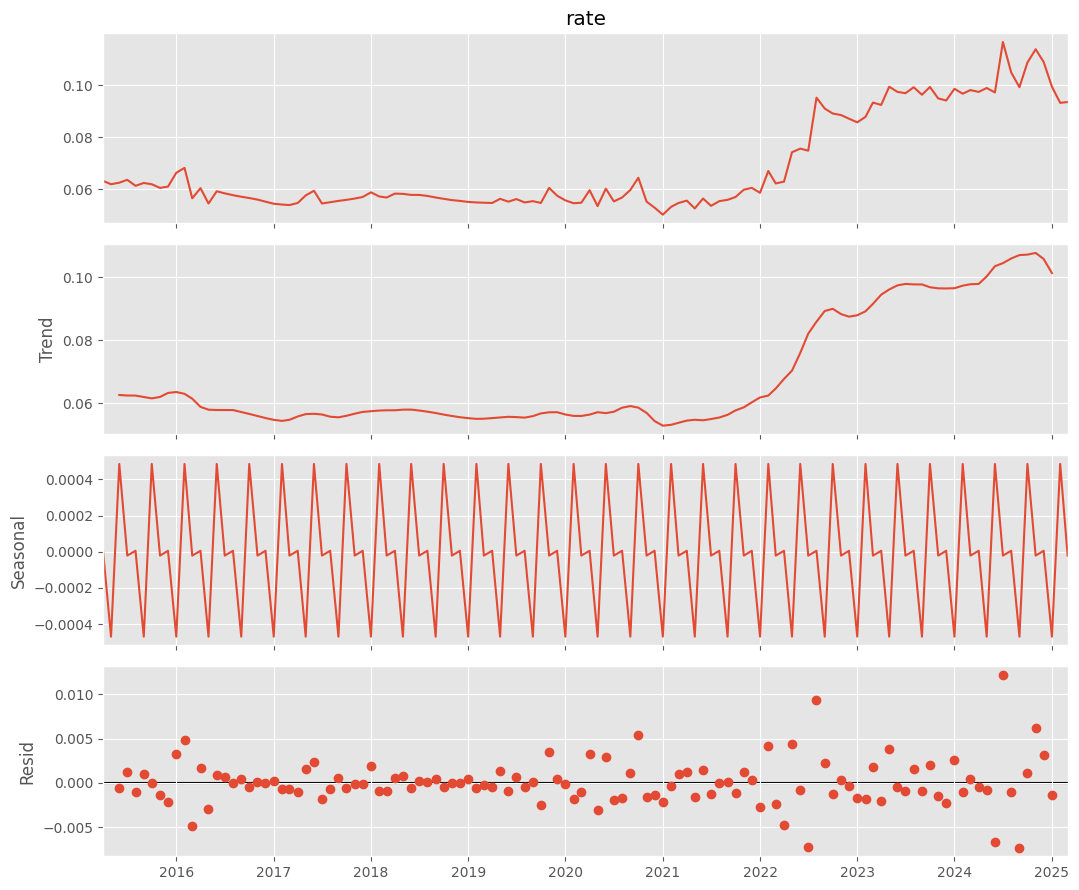

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(data['rate'], model='additive', period=4)
fig = decomposition.plot()
plt.show()


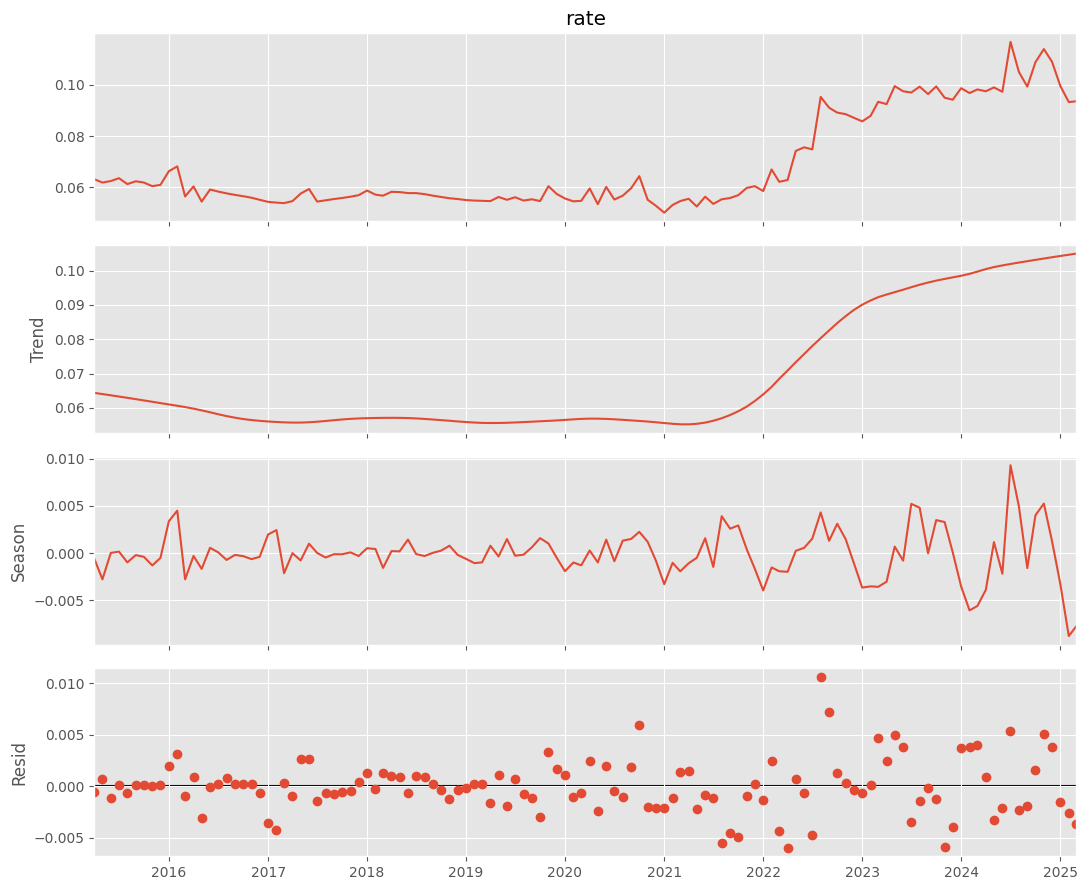

In [ ]:
from statsmodels.tsa.seasonal import STL
result = STL(data['rate'], period=12).fit()
result.plot()
plt.show()
# no seasonality

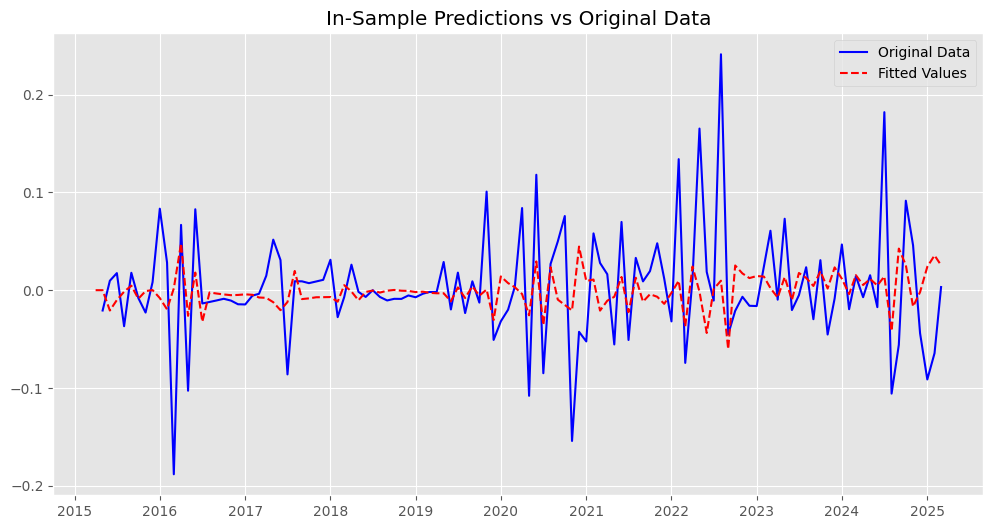

In [ ]:
fitted_values = model_fit.predict(start=data.index[0], end=data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(data['log_diff_1'], label='Original Data', color='blue')
plt.plot(fitted_values, label='Fitted Values', color='red', linestyle='--')
plt.title('In-Sample Predictions vs Original Data')
plt.legend()
plt.show()

In [ ]:
fitted_values

2015-04-01    0.000000
2015-05-01    0.000000
2015-06-01   -0.020784
2015-07-01   -0.010093
2015-08-01   -0.001572
                ...   
2024-11-01   -0.016811
2024-12-01   -0.001946
2025-01-01    0.023909
2025-02-01    0.035579
2025-03-01    0.025514
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

In [ ]:
result = adfuller(res.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.803676720603171
p-value: 2.0793775682261264e-14


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(res.dropna(), lags=20)  
print(lb_test.lb_pvalue)  

1     0.552170
2     0.291954
3     0.474122
4     0.642171
5     0.742697
6     0.532713
7     0.618908
8     0.691299
9     0.728580
10    0.774842
11    0.812370
12    0.868391
13    0.716341
14    0.747574
15    0.781024
16    0.778049
17    0.805735
18    0.686681
19    0.706828
20    0.762078
Name: lb_pvalue, dtype: float64


Residuals are white noise

# Forecasting

The time series data has been split into 80-20 to assess the forecast accuracy.